In [3]:
!pip3 install torchfusion_utils

In [4]:
from PIL import Image

In [5]:
from torchfusion_utils.fp16 import convertToFP16
from torchfusion_utils.initializers import *
from torchfusion_utils.metrics import Accuracy
from torchfusion_utils.models import load_model,save_model

In [6]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [7]:
transforms_train = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

transforms_test = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

batch_sizes = 64
test_data_dir = './Wildfire-smoke/Test'
train_data_dir = './Wildfire-smoke/Train'

train_dir = datasets.ImageFolder(root=train_data_dir, transform=transforms_train)
test_dir = datasets.ImageFolder(root=test_data_dir, transform=transforms_test)

train_data_loader = torch.utils.data.DataLoader(train_dir, batch_size=batch_sizes, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dir, batch_size=batch_sizes, shuffle=True)

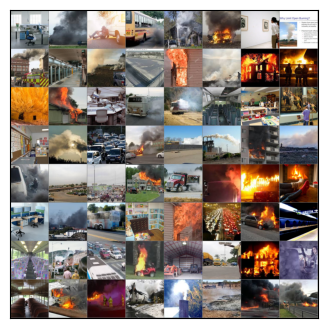

In [8]:
images, labels = next(iter(train_data_loader))

def img_disp(image, title=None):
    image = image/2 + 0.5
    numpy_image = image.numpy()
    transposed_numpy_image = np.transpose(numpy_image, (1, 2, 0))
    plt.figure(figsize=(20, 4))
    plt.imshow(transposed_numpy_image)
    plt.yticks([])
    plt.xticks([])
    if title:
        plt.title(title)
    plt.show

img_disp(torchvision.utils.make_grid(images))

In [9]:
ResNet = models.resnet50(num_classes=3)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
Model = ResNet

Model = Model.to(device)

learn_rate = 0.001

criteria = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(Model.parameters(), learn_rate=learn_rate)

Model,optimizer = convertToFP16(Model, optimizer)

milestones = [100, 150]

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

In [12]:
def model_traing_and_validation_loop(Model, Total_epoch, save_path):

    Total_epoch = Total_epoch

    save_model_criterion = 0

    train_loss_arr = []

    validation_loss_array = []

    train_accu = Accuracy()

    validation_acc = Accuracy(topK=1)

    for i in range(Total_epoch):

        total_test_data = 0

        total_train_data = 0

        correct_test_data = 0

        training_loss = 0

        validation_loss = 0

        train_accu.reset()

        for data, target in train_data_loader:

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            predictions = Model(data)

            loss = criteria(predictions, target)

            optimizer.backward(loss)

            optimizer.step()

            training_loss += loss.item()*data.size(0)

            train_accu.update(predictions, target)

        scheduler.step()

        with torch.no_grad():

            validation_acc.reset()

            for data, target in test_data_loader:

                data, target = data.to(device), target.to(device)

                predictions = Model(data)

                loss = criteria(predictions, target)

                validation_acc.update(predictions, target)

                total_test_data += target.size(0)

                validation_loss += loss.item()*data.size(0)


        training_loss = training_loss / len(train_dir)

        validation_loss = validation_loss / total_test_data

        train_loss_arr.append(training_loss)

        validation_loss_array.append(validation_loss)


        print(f'{i+1} / {Total_epoch} Training loss: {training_loss}, Train_Accuracy: {train_accu.getValue()}, Validation_loss: {validation_loss}, Validation_Accuracy: {validation_acc.getValue()}')

        if save_model_criterion < validation_acc.getValue():

            torch.save(Model, save_path)

            save_model_criterion = validation_acc.getValue()

            print('--------------------------Saving The Model---------------------------')


    plt.figure(figsize=(20, 4))

    x_axis = (range(Total_epoch))

    plt.plot(x_axis, train_loss_arr, 'r', validation_loss_array, 'b')

    plt.title('A graph of training loss vs validation loss')

    plt.legend(['train loss', 'validation loss'])

    plt.xlabel('Number of Epochs')

    plt.ylabel('Loss')

    return Model


1 / 20 Training loss: 1.1394502314814814, Train_Accuracy: 0.5055555701255798, Validation_loss: 0.7729231770833334, Validation_Accuracy: 0.746666669845581
--------------------------Saving Model---------------------------
2 / 20 Training loss: 0.588230613425926, Train_Accuracy: 0.7748148441314697, Validation_loss: 0.6023828125, Validation_Accuracy: 0.7699999809265137
--------------------------Saving Model---------------------------
3 / 20 Training loss: 0.48009765625, Train_Accuracy: 0.8203703761100769, Validation_loss: 0.7533072916666667, Validation_Accuracy: 0.7866666913032532
--------------------------Saving Model---------------------------
4 / 20 Training loss: 0.431470630787037, Train_Accuracy: 0.8355555534362793, Validation_loss: 0.5359375, Validation_Accuracy: 0.7933333516120911
--------------------------Saving Model---------------------------
5 / 20 Training loss: 0.41658058449074076, Train_Accuracy: 0.8418518304824829, Validation_loss: 0.567822265625, Validation_Accuracy: 0.7966

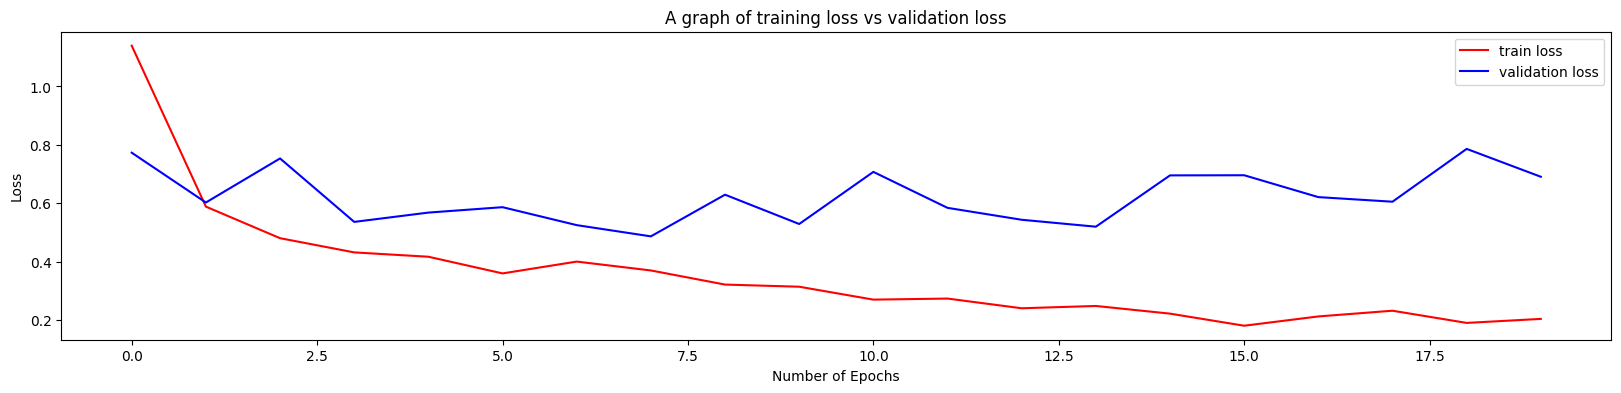

In [13]:
# Uncomment to retrain the model
Total_epoch = 20
model = model_traing_and_validation_loop(Model, Total_epoch, 'Comp_vision_project')

In [ ]:
load_saved_model=torch.load('Comp_vision_project')

In [170]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


img_path='testT.jpeg'

In [136]:
img1_path = 'fire_0004.jpg'

In [138]:
import matplotlib.pyplot as plt
def inferenceing_function(img_path):

    def img_disp(img_path):

        # plt.figure(figsize=(30, 6))
        # plt.imshow(Image.open(img_path))
        # plt.yticks([])
        # plt.xticks([])

        # plt.show()
        return 'Image of:'

    def model_inference_results():

        transformer = transforms.Compose([transforms.Resize(225),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5],
                                                          [0.5, 0.5, 0.5])])
        img = Image.open(img_path)
        img_processed = transformer(img).unsqueeze(0)
        img_var = Variable(img_processed, requires_grad= False)
        img_var = img_var.cuda()
        load_saved_model.eval()
        logp = load_saved_model(img_var)
        expp = torch.softmax(logp, dim=1)
        confidence, clas = expp.topk(1, dim=1)

        return f'Class: {clas}', f'Confidence score: {confidence.item()}'



    return (img_disp(img_path), *model_inference_results())

In [139]:
inferenceing_function(img1_path)

('Image of:', "Class: tensor([[0]], device='cuda:0')", 'Confidence score: 1.0')

In [140]:
img2_path = 'nofire_0032.jpg'
inferenceing_function(img2_path)

('Image of:',
 "Class: tensor([[2]], device='cuda:0')",
 'Confidence score: 0.57666015625')

In [141]:
img3_path = 'smoke1.jpg'
img4_path = 'nofire_0267.jpg'
img5_path = 'fire_0383.jpg'
img6_path = 'fire_0390.jpg'
img7_path = 'nofire_0270.jpg'
img8_path = 'smoke2.jpg'
img9_path = 'fire_0403.jpg'
img10_path = 'smoke3.jpg'
img11_path = 'fire_0426.jpg'


In [115]:
# json_d = inferenceing_function(img3_path)[2].split(':')[1]
# print(json_d[2].split(':')[1])

Text(0.5, 0, 'Fire')

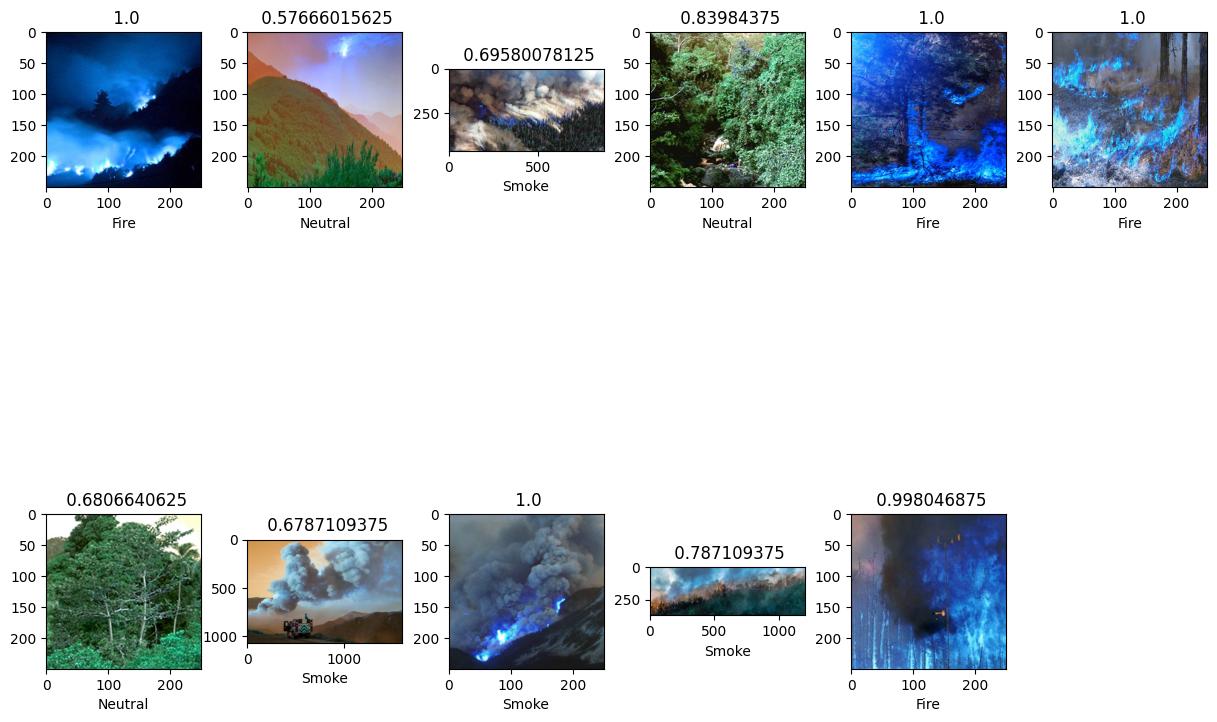

In [165]:
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(12, 12))

# setting values to rows and column variables
rows = 2
columns = 6

# reading images
Image1 = cv2.imread(img1_path)
Image2 = cv2.imread(img2_path)
Image3 = cv2.imread(img3_path)
Image4 = cv2.imread(img4_path)
Image5 = cv2.imread(img5_path)
Image6 = cv2.imread(img6_path)
Image7 = cv2.imread(img7_path)
Image8 = cv2.imread(img8_path)
Image9 = cv2.imread(img9_path)
Image10 = cv2.imread(img10_path)
Image11 = cv2.imread(img11_path)

image_array = [Image1, Image2, Image3, Image4, Image5, Image5, Image6, Image7, Image8, Image9, Image10, Image11]

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
json_d = inferenceing_function(img1_path)
# print(json_d)
plt.title(json_d[2].split(':')[1])
fig.tight_layout(pad=0.1)


###############
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
json_d = inferenceing_function(img2_path)
plt.title(json_d[2].split(':')[1])
fig.tight_layout(pad=0.1)


###############
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
json_d = inferenceing_function(img3_path)
plt.title(json_d[2].split(':')[1])
fig.tight_layout(pad=0.1)


###############
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(Image4)
json_d = inferenceing_function(img4_path)
plt.title(json_d[2].split(':')[1])
fig.tight_layout(pad=0.1)


###############
fig.add_subplot(rows, columns, 5)

# showing image
plt.imshow(Image5)
json_d = inferenceing_function(img5_path)
plt.title(json_d[2].split(':')[1])
fig.tight_layout(pad=0.1)


###############
fig.add_subplot(rows, columns, 6)

# showing image
plt.imshow(Image6)
json_d = inferenceing_function(img6_path)
plt.title(json_d[2].split(':')[1])
fig.tight_layout(pad=0.1)


###############
fig.add_subplot(rows, columns, 7)

# showing image
plt.imshow(Image7)
json_d = inferenceing_function(img7_path)
plt.title(json_d[2].split(':')[1])
fig.tight_layout(pad=0.1)


###############
fig.add_subplot(rows, columns, 8)

# showing image
plt.imshow(Image8)
json_d = inferenceing_function(img8_path)
plt.title(json_d[2].split(':')[1])
fig.tight_layout(pad=0.1)


###############
fig.add_subplot(rows, columns, 9)

# showing image
plt.imshow(Image9)
json_d = inferenceing_function(img9_path)
plt.title(json_d[2].split(':')[1])
fig.tight_layout(pad=0.1)


###############
fig.add_subplot(rows, columns, 10)

# showing image
plt.imshow(Image10)
json_d = inferenceing_function(img10_path)
plt.title(json_d[2].split(':')[1])



###############
fig.add_subplot(rows, columns, 11)

# showing image
plt.imshow(Image11)
json_d = inferenceing_function(img11_path)
plt.title(json_d[2].split(':')[1])





In [171]:
#The following two installation steps are needed to generate a PDF version of the notebook
#(These lines are needed within Google Colab, but are not needed within a local version of Jupyter notebook)
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc
!pip install --quiet pypandoc

In [173]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/comp_vision_proj.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/comp_vision_proj.ipynb to PDF
[NbConvertApp] Support files will be in comp_vision_proj_files/
[NbConvertApp] Making directory ./comp_vision_proj_files
[NbConvertApp] Making directory ./comp_vision_proj_files
[NbConvertApp] Making directory ./comp_vision_proj_files
[NbConvertApp] Writing 61946 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 801155 bytes to /content/drive/MyDrive/Colab Notebooks/comp_vision_proj.pdf
